# Classifiers - busy vs relaxed - with TFv1
Exploring different classifiers with with the contractive autoencoder. It needs the TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Contractive Autoencoder](#Contractive-Autoencoder)  

classifiers:  
[Simple dense classifier](#Simple-dense-classifier)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Nadam
# need to disable eager execution for .get_weights() in contractive autoencoder loss to work
tf.compat.v1.disable_eager_execution() # required for the contractive autoencoder
import tensorflow.keras.backend as K
tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import json
from datetime import datetime
import warnings
import matplotlib.pyplot as plt

In [2]:
# from https://github.com/ageron/handson-ml/blob/master/extra_tensorflow_reproducibility.ipynb
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                        inter_op_parallelism_threads=1)

with tf.compat.v1.Session(config=config) as sess:
    #... this will run single threaded
    pass

In [3]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [4]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 when starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [5]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [6]:
def get_busy_vs_relax_timeframes_br_hb(path, ident, seconds):
    """Returns raw data from either 'on task' or 'relax' time frames and their class (0 or 1)."""
    
    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))

        ### task versus relax (1 sample each)
        dataextract = dataextractor.DataExtractor(data[0][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  data[1][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  samp_rate)

        dataextract_relax = dataextractor.DataExtractor(data[0][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        data[1][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        samp_rate)

        try:

            # get extracted features for breathing
            tmpBR_busy = dataextract.extract_from_breathing_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpBR_relax = dataextract_relax.extract_from_breathing_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])
            #get extracted features for heartbeat
            tmpHB_busy = dataextract.extract_from_heartbeat_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpHB_relax = dataextract.extract_from_heartbeat_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])

            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tasks_y, 1))
            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tmp_tasks_y, 0))

            # put busy frames then relaxed frames under the previous frames
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

        except ValueError:
#             print(ident)  # ignore short windows
            continue

        # put busy frames then relaxed frames under the previous frames
        tasks_data = np.vstack((tasks_data, dataextract.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 1))
        tasks_data = np.vstack((tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 0))

        breathing = np.vstack((breathing, tmpBR_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
        breathing = np.vstack((breathing, tmpBR_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

        heartbeat = np.vstack((heartbeat, tmpHB_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
        heartbeat = np.vstack((heartbeat, tmpHB_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

    return tasks_data, tasks_y, breathing, heartbeat

In [7]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes

            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [8]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [9]:
def set_random_seeds():
    # clear session and set seeds again
    # cannot clear session due to tf.compat.v1 graphs, but add tf.compat.v1.set_random_seed
#     K.clear_session()
    tf.compat.v1.set_random_seed(2)
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [10]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [11]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-2], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_train = MinMaxScaler().fit_transform(phase_all_train.T).T

# load all validation phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-2:], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_valid = MinMaxScaler().fit_transform(phase_all_valid.T).T

In [12]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [13]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [14]:
# AE Training params
batch_size = 128
epochs = 1000
encoding_dim = 30
ae_encoded_shape = np.empty((0,encoding_dim))

In [15]:
def compare_plot_n(data1, data2, plot_n=12):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data2[i])

#### Contractive Autoencoder
From: https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

In [16]:
# define a function to be able to access the autoencoder in the loss funciton
def loss_with_params(autoencoder):
    # loss function from https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/
    def contractive_loss(y_pred, y_true):

        lam = 1e-4
        mse = K.mean(K.square(y_true - y_pred), axis=1)

        W = K.variable(value=autoencoder.get_layer('encoded').get_weights()[0])  # N x N_hidden
        W = K.transpose(W)  # N_hidden x N
        h = autoencoder.get_layer('encoded').output
        dh = h * (1 - h)  # N_batch x N_hidden

        # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
        contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

        return mse + contractive
    return contractive_loss

In [17]:
def contractive_ae(x, encoding_dim=64, encoded_as_model=False):
    # From https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

    input_data = Input(shape=x[0].shape, name="input")
    encoded = Dense(encoding_dim, activation='relu', name='encoded')(input_data)
    outputs = Dense(x[0].shape[0], activation='sigmoid', name="output")(encoded)

    autoencoder = Model(input_data, outputs, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss=loss_with_params(autoencoder), metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [18]:
set_random_seeds()
ct_ae, ct_enc = contractive_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
ct_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

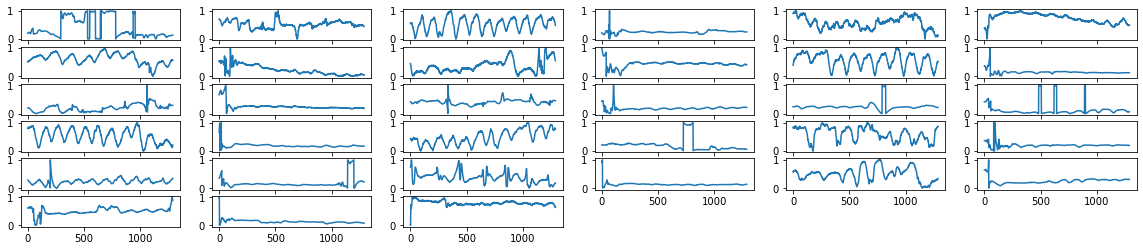

<Figure size 432x288 with 0 Axes>

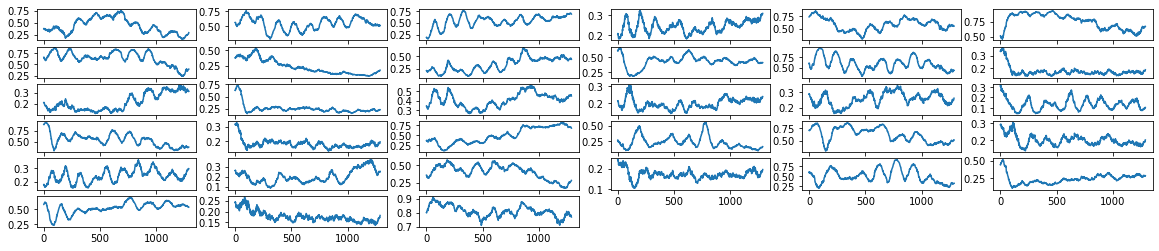

In [19]:
data2 = ct_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

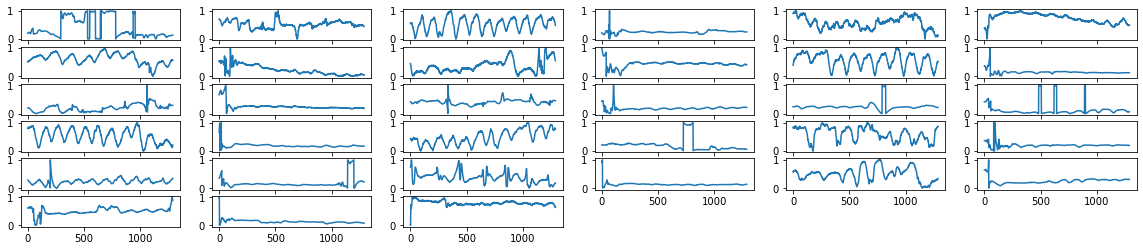

<Figure size 432x288 with 0 Axes>

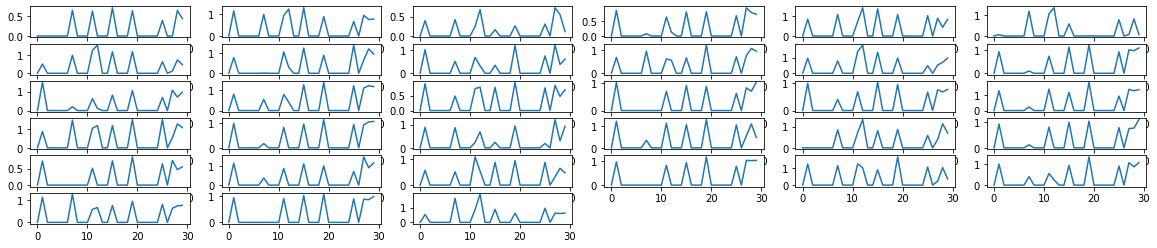

In [20]:
data2 = ct_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Store the encoded representations in the data dictionary:

In [21]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    ct_data = ct_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['contractive_encoded'] = ct_data

Helper function to get data from the dictionary:

In [22]:
def get_ident_data_from_dict(idents, data_dict):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    contractive_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        y = np.vstack((y, data_dict[tmp_id]['y']))
        contractive_encoded = np.vstack((contractive_encoded, data_dict[tmp_id]['contractive_encoded']))
    
    return y, phase, contractive_encoded

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [23]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['contractive'] = []
    accs['test id'] = []
    start_time = datetime.now()

    with tf.compat.v1.Session(config=config) as sess:
        # leave out person out validation
        for i in range(n):

            # print current iteration and time elapsed from start
            print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

            ## ----- Data preparation:
            validation_idents = [idents[i]]
            test_idents = [idents[i-1]]

            train_idents = []
            for ident in idents:
                if (ident not in test_idents) and (ident not in validation_idents):
                    train_idents.append(ident)

            # save test id to see which id yielded which accuracies
            accs['test id'].append(test_idents[0])

            # Load train data
            train_data = get_ident_data_from_dict(train_idents, data_dict)
            y_train = train_data[0]

            # Load validation data
            valid_data = get_ident_data_from_dict(validation_idents, data_dict)
            y_valid = valid_data[0]

            # Load test data
            test_data = get_ident_data_from_dict(test_idents, data_dict)
            y_test = test_data[0]

            data_names_by_index = ['y', 'phase', 'contractive']

            # Loop over all data that will be used for classification and send it to the classifier
            # index 0 is y so we skip it
            for index in range(1, len(test_data)):
                set_random_seeds()
                train_x = train_data[index]
                valid_x = valid_data[index]
                test_x = test_data[index]

                # Scale data
                if should_scale_data:
                    # Scale with standard scaler
                    sscaler = StandardScaler()
                    sscaler.fit(train_x)
                    train_x = sscaler.transform(train_x)

                    # Scale valid and test with train's scaler
                    valid_x = sscaler.transform(valid_x)
                    test_x = sscaler.transform(test_x)
                
                # Initialize variables
                tmp_acc = []
                data_name = data_names_by_index[index]

                for index in range(num_loops_to_average_over):
                    curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                    tmp_acc.append(curr_acc)

                # Store accuracy
                curr_acc = np.mean(tmp_acc)
                accs[data_name].append(curr_acc)


        # Print total time required to run this
        end_time = datetime.now()
        elapsed_time = end_time - start_time
        print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [24]:
params_dense_phase = {
    'dropout': 0.4,
    'hidden_size': 26,
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': Adam,
    'batch_size': 128,
    'learning_rate': 0.001,
    'epochs': 300
}

In [25]:
params_dense_ae_enc = {
    'dropout': 0.05,
    'hidden_size': 34,
    'activation': 'relu',
    'loss': 'binary_crossentropy',
    'optimizer': Adam,
    'learning_rate': 0.005,
    'batch_size': 106,
    'epochs': 200
}

In [26]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_dense_ae_enc
    if (data_name == 'phase'):
        params = params_dense_phase
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['hidden_size']))
    model.add(Activation(params['activation']))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [27]:
accs = helper_loop(dense_train, idents, n=n, should_scale_data=True)

iteration: 1 of 23 ; time elapsed: 0:00:00.006981
iteration: 2 of 23 ; time elapsed: 0:00:12.953578
iteration: 3 of 23 ; time elapsed: 0:00:25.792280
iteration: 4 of 23 ; time elapsed: 0:00:39.638345
iteration: 5 of 23 ; time elapsed: 0:00:53.210171
iteration: 6 of 23 ; time elapsed: 0:01:08.317321
iteration: 7 of 23 ; time elapsed: 0:01:22.387651
iteration: 8 of 23 ; time elapsed: 0:01:36.871130
iteration: 9 of 23 ; time elapsed: 0:01:52.185787
iteration: 10 of 23 ; time elapsed: 0:02:07.509138
iteration: 11 of 23 ; time elapsed: 0:02:23.417348
iteration: 12 of 23 ; time elapsed: 0:02:38.979701
iteration: 13 of 23 ; time elapsed: 0:02:56.043608
iteration: 14 of 23 ; time elapsed: 0:03:13.658277
iteration: 15 of 23 ; time elapsed: 0:03:31.015738
iteration: 16 of 23 ; time elapsed: 0:03:49.342903
iteration: 17 of 23 ; time elapsed: 0:04:08.449963
iteration: 18 of 23 ; time elapsed: 0:04:27.580165
iteration: 19 of 23 ; time elapsed: 0:04:47.872248
iteration: 20 of 23 ; time elapsed: 0:05

In [28]:
accuracies['simple_dense'] = accs

In [29]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.583333,0.708333,62i9y
1,0.617647,0.823529,2gu87
2,0.666667,0.750000,iz2ps
3,0.470588,0.676471,1mpau
4,0.566667,0.600000,7dwjy
5,0.625000,0.843750,7swyk
6,0.687500,0.593750,94mnx
7,0.600000,0.500000,bd47a
8,0.533333,0.500000,c24ur
9,0.466667,0.700000,ctsax


In [30]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.433333     0.468750
max     0.718750     0.843750
mean    0.580666     0.642279
median  0.600000     0.656250


#### LSTM-based classifier  
based on the original author's code

In [31]:
params_lstm_phase = {
    'kernel_size': 4,
    'filters': 32,
    'strides': 2,
    'pool_size': 4,
    'dropout': 0.1,
    'lstm_output_size': 22,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': Nadam,
    'learning_rate': 0.005,
    'batch_size': 168,
    'epochs': 200
}

In [32]:
params_lstm_ae_enc = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.01,
    'lstm_output_size': 32,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'poisson',
    'optimizer': Nadam,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100
}

In [33]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_lstm_ae_enc
    if (data_name == 'phase'):
        params = params_lstm_phase
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    
    if (data_name == 'phase'):
        model.add(Conv1D(params['filters'],
                         params['kernel_size'],
                         padding='valid',
                         activation=params['activation'],
                         strides=params['strides']))
        model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(1))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [34]:
accs = helper_loop(LSTM_train, idents, n=n)

iteration: 1 of 23 ; time elapsed: 0:00:00.005984
iteration: 2 of 23 ; time elapsed: 0:01:29.270987
iteration: 3 of 23 ; time elapsed: 0:02:58.509564
iteration: 4 of 23 ; time elapsed: 0:04:44.808019
iteration: 5 of 23 ; time elapsed: 0:06:33.875740
iteration: 6 of 23 ; time elapsed: 0:08:20.318922
iteration: 7 of 23 ; time elapsed: 0:10:04.265249
iteration: 8 of 23 ; time elapsed: 0:12:05.325063
iteration: 9 of 23 ; time elapsed: 0:14:05.173979
iteration: 10 of 23 ; time elapsed: 0:15:55.342604
iteration: 11 of 23 ; time elapsed: 0:18:08.461178
iteration: 12 of 23 ; time elapsed: 0:20:02.534321
iteration: 13 of 23 ; time elapsed: 0:22:12.153327
iteration: 14 of 23 ; time elapsed: 0:24:11.942082
iteration: 15 of 23 ; time elapsed: 0:26:22.174865
iteration: 16 of 23 ; time elapsed: 0:28:25.948518
iteration: 17 of 23 ; time elapsed: 0:30:40.316005
iteration: 18 of 23 ; time elapsed: 0:32:46.938828
iteration: 19 of 23 ; time elapsed: 0:35:07.334041
iteration: 20 of 23 ; time elapsed: 0:36

In [35]:
accuracies['LSTM'] = accs

In [36]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.666667,0.583333,62i9y
1,0.735294,0.705882,2gu87
2,0.916667,0.666667,iz2ps
3,0.558824,0.441176,1mpau
4,0.533333,0.466667,7dwjy
5,0.843750,0.781250,7swyk
6,0.718750,0.625000,94mnx
7,0.700000,0.566667,bd47a
8,0.633333,0.400000,c24ur
9,0.633333,0.600000,ctsax


In [37]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.500000     0.400000
max     0.916667     0.781250
mean    0.638603     0.558946
median  0.633333     0.562500


#### kNN

In [38]:
params_knn_phase = {
    'n_neighbors': 5,
    'metric': 'cosine'
}

In [39]:
params_knn_ae_enc = {
    'n_neighbors': 15,
    'metric': 'cosine'
}

In [40]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier(params):
    model = KNeighborsClassifier(n_neighbors=params['n_neighbors'], metric=params['metric'])
    return model

In [41]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_knn_ae_enc
    if (data_name == 'phase'):
        params = params_knn_phase
    
    model = KNN_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [42]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00.011969
iteration: 2 of 23 ; time elapsed: 0:00:00.089761
iteration: 3 of 23 ; time elapsed: 0:00:00.165556
iteration: 4 of 23 ; time elapsed: 0:00:00.239933
iteration: 5 of 23 ; time elapsed: 0:00:00.311367
iteration: 6 of 23 ; time elapsed: 0:00:00.382173
iteration: 7 of 23 ; time elapsed: 0:00:00.454553
iteration: 8 of 23 ; time elapsed: 0:00:00.526608
iteration: 9 of 23 ; time elapsed: 0:00:00.595977
iteration: 10 of 23 ; time elapsed: 0:00:00.665762
iteration: 11 of 23 ; time elapsed: 0:00:00.732583
iteration: 12 of 23 ; time elapsed: 0:00:00.809378
iteration: 13 of 23 ; time elapsed: 0:00:00.886173
iteration: 14 of 23 ; time elapsed: 0:00:00.958008
iteration: 15 of 23 ; time elapsed: 0:00:01.024802
iteration: 16 of 23 ; time elapsed: 0:00:01.087633
iteration: 17 of 23 ; time elapsed: 0:00:01.155453
iteration: 18 of 23 ; time elapsed: 0:00:01.220278
iteration: 19 of 23 ; time elapsed: 0:00:01.282113
iteration: 20 of 23 ; time elapsed: 0:00

In [43]:
accuracies['kNN'] = accs

In [44]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.416667,0.708333,62i9y
1,0.735294,0.735294,2gu87
2,0.611111,0.638889,iz2ps
3,0.764706,0.529412,1mpau
4,0.800000,0.566667,7dwjy
5,0.750000,0.843750,7swyk
6,0.718750,0.687500,94mnx
7,0.700000,0.566667,bd47a
8,0.466667,0.466667,c24ur
9,0.733333,0.566667,ctsax


In [45]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.416667     0.375000
max     0.800000     0.843750
mean    0.630818     0.612779
median  0.625000     0.617647


####  SVC

In [46]:
params_svc_phase = {
    'C': 10,
    'kernel': 'rbf',
    'gamma': 'scale'
}

In [47]:
params_svc_ae_enc = {
    'C': 3,
    'kernel': 'rbf',
    'gamma': 'auto'
}

In [48]:
from sklearn.svm import SVC

def SVC_classifier(params):
    model = SVC(random_state=42, C=params['C'], kernel=params['kernel'], gamma=params['gamma'])
    return model

In [49]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_svc_ae_enc
    if (data_name == 'phase'):
        params = params_svc_phase
    
    model = SVC_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [50]:
accs = helper_loop(SVC_train, idents, n=n, num_loops_to_average_over=5)

iteration: 1 of 23 ; time elapsed: 0:00:00.007978
iteration: 2 of 23 ; time elapsed: 0:00:03.172460
iteration: 3 of 23 ; time elapsed: 0:00:06.343568
iteration: 4 of 23 ; time elapsed: 0:00:09.477340
iteration: 5 of 23 ; time elapsed: 0:00:12.591513
iteration: 6 of 23 ; time elapsed: 0:00:15.744082
iteration: 7 of 23 ; time elapsed: 0:00:18.931501
iteration: 8 of 23 ; time elapsed: 0:00:21.966925
iteration: 9 of 23 ; time elapsed: 0:00:25.116593
iteration: 10 of 23 ; time elapsed: 0:00:28.254188
iteration: 11 of 23 ; time elapsed: 0:00:31.410338
iteration: 12 of 23 ; time elapsed: 0:00:34.518048
iteration: 13 of 23 ; time elapsed: 0:00:37.644042
iteration: 14 of 23 ; time elapsed: 0:00:40.743466
iteration: 15 of 23 ; time elapsed: 0:00:43.750056
iteration: 16 of 23 ; time elapsed: 0:00:46.888680
iteration: 17 of 23 ; time elapsed: 0:00:49.946139
iteration: 18 of 23 ; time elapsed: 0:00:53.013639
iteration: 19 of 23 ; time elapsed: 0:00:56.095322
iteration: 20 of 23 ; time elapsed: 0:00

In [51]:
accuracies['SVC'] = accs

In [52]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.666667,0.666667,62i9y
1,0.647059,0.764706,2gu87
2,0.750000,0.694444,iz2ps
3,0.558824,0.441176,1mpau
4,0.666667,0.700000,7dwjy
5,0.687500,0.781250,7swyk
6,0.625000,0.625000,94mnx
7,0.533333,0.500000,bd47a
8,0.600000,0.533333,c24ur
9,0.700000,0.666667,ctsax


In [53]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.375000     0.441176
max     0.750000     0.781250
mean    0.612727     0.613440
median  0.617647     0.625000


#### Random Forest

In [54]:
params_rf_phase = {
    'n_estimators': 180,
    'max_depth': 50,
    'min_samples_split': 4,
    'min_samples_leaf': 1,
    'oob_score': False,
    'ccp_alpha': 0.001
}

In [55]:
params_rf_ae_enc = {
    'n_estimators': 130,
    'max_depth': 100,
    'min_samples_split': 5,
    'min_samples_leaf': 5,
    'oob_score': True,
    'ccp_alpha': 0.005
}

In [56]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier(params):
    model = RandomForestClassifier(random_state=42,
                                   n_estimators = params['n_estimators'],
                                   criterion = 'entropy',
                                   max_depth = params['max_depth'],
                                   min_samples_split = params['min_samples_split'],
                                   min_samples_leaf = params['min_samples_leaf'],
                                   oob_score = params['oob_score'],
                                   ccp_alpha = params['ccp_alpha'],
                                   max_features = 'log2',
                                   bootstrap = True)
    return model

In [57]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_rf_ae_enc
    if (data_name == 'phase'):
        params = params_rf_phase
    
    model = random_forest_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [58]:
accs = helper_loop(random_forest_train, idents, n=n, num_loops_to_average_over=5, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00.005983
iteration: 2 of 23 ; time elapsed: 0:00:07.855154
iteration: 3 of 23 ; time elapsed: 0:00:15.821850
iteration: 4 of 23 ; time elapsed: 0:00:23.253981
iteration: 5 of 23 ; time elapsed: 0:00:30.441766
iteration: 6 of 23 ; time elapsed: 0:00:38.214970
iteration: 7 of 23 ; time elapsed: 0:00:46.261814
iteration: 8 of 23 ; time elapsed: 0:00:53.995375
iteration: 9 of 23 ; time elapsed: 0:01:01.718035
iteration: 10 of 23 ; time elapsed: 0:01:09.361974
iteration: 11 of 23 ; time elapsed: 0:01:17.047897
iteration: 12 of 23 ; time elapsed: 0:01:24.467004
iteration: 13 of 23 ; time elapsed: 0:01:31.772750
iteration: 14 of 23 ; time elapsed: 0:01:39.173787
iteration: 15 of 23 ; time elapsed: 0:01:46.654737
iteration: 16 of 23 ; time elapsed: 0:01:54.431286
iteration: 17 of 23 ; time elapsed: 0:02:01.844794
iteration: 18 of 23 ; time elapsed: 0:02:09.541459
iteration: 19 of 23 ; time elapsed: 0:02:17.334468
iteration: 20 of 23 ; time elapsed: 0:02

In [59]:
accuracies['random_forest'] = accs

In [60]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.750000,0.625000,62i9y
1,0.588235,0.852941,2gu87
2,0.750000,0.722222,iz2ps
3,0.647059,0.617647,1mpau
4,0.566667,0.500000,7dwjy
5,0.750000,0.812500,7swyk
6,0.625000,0.593750,94mnx
7,0.633333,0.466667,bd47a
8,0.666667,0.600000,c24ur
9,0.700000,0.733333,ctsax


In [61]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.531250     0.466667
max     0.823529     0.852941
mean    0.656694     0.633657
median  0.647059     0.617647


#### Naive Bayesian

In [62]:
from sklearn.naive_bayes import GaussianNB

def naive_bayesian_classifier():
    model = GaussianNB()
    return model

In [63]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = naive_bayesian_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [64]:
accs = helper_loop(naive_bayesian_train, idents, n=n, should_scale_data=True)

iteration: 1 of 23 ; time elapsed: 0:00:00.006983
iteration: 2 of 23 ; time elapsed: 0:00:00.080817
iteration: 3 of 23 ; time elapsed: 0:00:00.174567
iteration: 4 of 23 ; time elapsed: 0:00:00.275298
iteration: 5 of 23 ; time elapsed: 0:00:00.354595
iteration: 6 of 23 ; time elapsed: 0:00:00.430392
iteration: 7 of 23 ; time elapsed: 0:00:00.499714
iteration: 8 of 23 ; time elapsed: 0:00:00.577506
iteration: 9 of 23 ; time elapsed: 0:00:00.664274
iteration: 10 of 23 ; time elapsed: 0:00:00.738105
iteration: 11 of 23 ; time elapsed: 0:00:00.811879
iteration: 12 of 23 ; time elapsed: 0:00:00.883687
iteration: 13 of 23 ; time elapsed: 0:00:00.956493
iteration: 14 of 23 ; time elapsed: 0:00:01.030297
iteration: 15 of 23 ; time elapsed: 0:00:01.100110
iteration: 16 of 23 ; time elapsed: 0:00:01.174936
iteration: 17 of 23 ; time elapsed: 0:00:01.246717
iteration: 18 of 23 ; time elapsed: 0:00:01.319521
iteration: 19 of 23 ; time elapsed: 0:00:01.391329
iteration: 20 of 23 ; time elapsed: 0:00

In [65]:
accuracies['naive_bayesian'] = accs

In [66]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.666667,0.791667,62i9y
1,0.411765,0.529412,2gu87
2,0.500000,0.500000,iz2ps
3,0.558824,0.470588,1mpau
4,0.466667,0.466667,7dwjy
5,0.656250,0.750000,7swyk
6,0.593750,0.593750,94mnx
7,0.566667,0.600000,bd47a
8,0.466667,0.466667,c24ur
9,0.633333,0.600000,ctsax


In [67]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.411765     0.466667
max     0.687500     0.791667
mean    0.528009     0.586555
median  0.500000     0.588235


#### XGBoost

In [68]:
params_xgb_phase = {
    'n_estimators': 50,
    'max_depth': 50,
    'booster': 'gbtree'
}

In [69]:
params_xgb_ae_enc = {
    'n_estimators': 50,
    'max_depth': 5,
    'booster': 'gbtree'
}

In [70]:
from xgboost import XGBClassifier

def XGBoost_classifier(params):
    model = XGBClassifier(random_state=42,
                         n_estimators=params['n_estimators'],
                         max_depth=params['max_depth'])
    return model

In [71]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_xgb_ae_enc
    if (data_name == 'phase'):
        params = params_xgb_phase
    
    model = XGBoost_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [72]:
accs = helper_loop(XGBoost_train, idents, n=n, num_loops_to_average_over=5, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00.006982
iteration: 2 of 23 ; time elapsed: 0:00:09.415395
iteration: 3 of 23 ; time elapsed: 0:00:18.603019
iteration: 4 of 23 ; time elapsed: 0:00:26.825904
iteration: 5 of 23 ; time elapsed: 0:00:35.082079
iteration: 6 of 23 ; time elapsed: 0:00:42.977355
iteration: 7 of 23 ; time elapsed: 0:00:51.555822
iteration: 8 of 23 ; time elapsed: 0:00:59.412466
iteration: 9 of 23 ; time elapsed: 0:01:07.331758
iteration: 10 of 23 ; time elapsed: 0:01:15.310746
iteration: 11 of 23 ; time elapsed: 0:01:23.265956
iteration: 12 of 23 ; time elapsed: 0:01:31.424797
iteration: 13 of 23 ; time elapsed: 0:01:40.217145
iteration: 14 of 23 ; time elapsed: 0:01:48.278897
iteration: 15 of 23 ; time elapsed: 0:01:56.352699
iteration: 16 of 23 ; time elapsed: 0:02:04.205111
iteration: 17 of 23 ; time elapsed: 0:02:11.917914
iteration: 18 of 23 ; time elapsed: 0:02:19.821424
iteration: 19 of 23 ; time elapsed: 0:02:27.227845
iteration: 20 of 23 ; time elapsed: 0:02

In [73]:
accuracies['XGBoost'] = accs

In [74]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.583333,0.583333,62i9y
1,0.617647,0.705882,2gu87
2,0.638889,0.638889,iz2ps
3,0.676471,0.500000,1mpau
4,0.633333,0.466667,7dwjy
5,0.781250,0.781250,7swyk
6,0.531250,0.593750,94mnx
7,0.600000,0.500000,bd47a
8,0.666667,0.600000,c24ur
9,0.733333,0.666667,ctsax


In [75]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.437500     0.466667
max     0.794118     0.781250
mean    0.634925     0.596812
median  0.638889     0.593750


###  Compare Accuracies

Save all accuracies to results csv file:

In [83]:
results_path = "results/BvR/BvR-all-tfv1.csv"

# Make a dataframe from the accuracies
accs_dataframe = pandas.DataFrame(accuracies).T
# Save dataframe to file
accs_dataframe.to_csv(results_path, mode='w')

Print min, max, mean, median for each clasifier/autoencoder combination:

In [84]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)
    print("\n")

----------- simple_dense: -----------
           phase  contractive
min     0.433333     0.468750
max     0.718750     0.843750
mean    0.580666     0.642279
median  0.600000     0.656250


----------- LSTM: -----------
           phase  contractive
min     0.500000     0.400000
max     0.916667     0.781250
mean    0.638603     0.558946
median  0.633333     0.562500


----------- kNN: -----------
           phase  contractive
min     0.416667     0.375000
max     0.800000     0.843750
mean    0.630818     0.612779
median  0.625000     0.617647


----------- SVC: -----------
           phase  contractive
min     0.375000     0.441176
max     0.750000     0.781250
mean    0.612727     0.613440
median  0.617647     0.625000


----------- random_forest: -----------
           phase  contractive
min     0.531250     0.466667
max     0.823529     0.852941
mean    0.656694     0.633657
median  0.647059     0.617647


----------- naive_bayesian: -----------
           phase  contractive
min  

Print all accuracies in table form:

In [85]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:
       phase  contractive test id
0   0.583333     0.708333   62i9y
1   0.617647     0.823529   2gu87
2   0.666667     0.750000   iz2ps
3   0.470588     0.676471   1mpau
4   0.566667     0.600000   7dwjy
5   0.625000     0.843750   7swyk
6   0.687500     0.593750   94mnx
7   0.600000     0.500000   bd47a
8   0.533333     0.500000   c24ur
9   0.466667     0.700000   ctsax
10  0.647059     0.617647   dkhty
11  0.625000     0.656250   e4gay
12  0.500000     0.468750   ef5rq
13  0.433333     0.500000   f1gjp
14  0.656250     0.687500   hpbxa
15  0.666667     0.750000   pmyfl
16  0.555556     0.666667   r89k1
17  0.468750     0.593750   tn4vl
18  0.531250     0.718750   td5pr
19  0.676471     0.558824   gyqu9
20  0.617647     0.676471   fzchw
21  0.441176     0.588235   l53hg
22  0.718750     0.593750   3n2f9


LSTM:
       phase  contractive test id
0   0.666667     0.583333   62i9y
1   0.735294     0.705882   2gu87
2   0.916667     0.666667   iz2ps
3   0.558824     0.441176 